## Telecom X – Parte 2: Prevendo Churn (Código)

In [127]:
import pandas as pd
import requests

# Link da API (arquivo JSON raw do GitHub)
api_url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'

try:
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        df_churn = pd.DataFrame(data)
        print("Dados extraídos e convertidos para DataFrame com sucesso!")
        print("\nVerificando as colunas originais do DataFrame:")
        print(df_churn.columns)
        df_churn.info()
    else:
        print(f"Erro ao acessar a API. Código de status: {response.status_code}")
        df_churn = None
except requests.exceptions.RequestException as e:
    print(f"Ocorreu um erro de conexão: {e}")
    df_churn = None

Dados extraídos e convertidos para DataFrame com sucesso!

Verificando as colunas originais do DataFrame:
Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [128]:
# Bloco de Transformação de Dados

# Expandindo as colunas com estruturas aninhadas
print("--- Expandindo colunas aninhadas ---")
# Convertendo o DataFrame para uma lista de dicionários para json_normalize
data_list = df_churn.to_dict('records')
df_churn = pd.json_normalize(data_list)

# Print columns after normalization to diagnose
print("Colunas após json_normalize:")
print(df_churn.columns)

# Ação 1: Tratamento da coluna 'account.Charges.Total'
print("--- 1. Tratando a coluna 'account.Charges.Total' ---")
# Substitui espaços vazios por valores nulos (NaN)
df_churn['account.Charges.Total'] = df_churn['account.Charges.Total'].replace(' ', pd.NA)
# Converte a coluna para tipo numérico, forçando valores não convertíveis a NaN
df_churn['account.Charges.Total'] = pd.to_numeric(df_churn['account.Charges.Total'], errors='coerce')

# Ação 2: Remoção de linhas com valores ausentes em 'account.Charges.Total'
df_churn.dropna(subset=['account.Charges.Total'], inplace=True)
print("Valores ausentes em 'account.Charges.Total' foram removidos.")

# Ação 3: Remoção da coluna 'customerID'
print("\n--- 2. Removendo a coluna 'customerID' ---")
if 'customerID' in df_churn.columns:
    df_churn.drop('customerID', axis=1, inplace=True)
    print("Coluna 'customerID' removida.")
else:
    print("A coluna 'customerID' não foi encontrada, não precisa ser removida.")

# Ação 4: Criação da nova coluna 'Contas_Diarias'
print("\n--- 3. Criando a coluna 'Contas_Diarias' ---")
df_churn['Contas_Diarias'] = df_churn['account.Charges.Monthly'] / 30.44
print("Coluna 'Contas_Diarias' criada com sucesso.")

# Ação 5: Padronização e tradução de colunas e valores
print("\n--- 4. Padronização e tradução de dados ---")
colunas_renomear = {
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'Idoso',
    'customer.Partner': 'Parceiro',
    'customer.Dependents': 'Dependentes',
    'customer.tenure': 'TempoServico',
    'phone.PhoneService': 'ServicoTelefone',
    'phone.MultipleLines': 'MultiplasLinhas',
    'internet.InternetService': 'ServicoInternet',
    'internet.OnlineSecurity': 'SegurancaOnline',
    'internet.OnlineBackup': 'BackupOnline',
    'internet.DeviceProtection': 'ProtecaoAparelho',
    'internet.TechSupport': 'SuporteTecnico',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingFilmes',
    'account.Contract': 'TipoContrato',
    'account.PaperlessBilling': 'FaturaDigital',
    'account.PaymentMethod': 'MetodoPagamento',
    'account.Charges.Monthly': 'CustoMensal',
    'account.Charges.Total': 'CustoTotal',
    'Churn': 'Evasao'
}
df_churn.rename(columns=colunas_renomear, inplace=True)

# Mapeando os valores categóricos
df_churn['Evasao'] = df_churn['Evasao'].map({'Yes': 1, 'No': 0})
df_churn['Genero'] = df_churn['Genero'].replace({'Male': 'Masculino', 'Female': 'Feminino'})
df_churn['Idoso'] = df_churn['Idoso'].replace({1: 'Sim', 0: 'Não'})

# Mapeamentos adicionais
sim_nao_map = {'Yes': 'Sim', 'No': 'Não'}
cols_para_traduzir_sim_nao = [
    'Parceiro', 'Dependentes', 'ServicoTelefone', 'FaturaDigital'
]
for col in cols_para_traduzir_sim_nao:
    df_churn[col] = df_churn[col].replace(sim_nao_map)

for col in ['SegurancaOnline', 'BackupOnline', 'ProtecaoAparelho', 'SuporteTecnico', 'StreamingTV', 'StreamingFilmes']:
    df_churn[col] = df_churn[col].replace({'No': 'Não', 'Yes': 'Sim', 'No internet service': 'Sem servico de internet'})

df_churn['TipoContrato'] = df_churn['TipoContrato'].replace({
    'Month-to-month': 'Mensal', 'One year': 'Anual', 'Two year': 'Dois anos'
})
df_churn['MetodoPagamento'] = df_churn['MetodoPagamento'].replace({
    'Electronic check': 'Cheque eletrônico', 'Mailed check': 'Cheque enviado',
    'Bank transfer (automatic)': 'Transferência bancária (automática)',
    'Credit card (automatic)': 'Cartão de crédito (automático)'
})

print("\n--- Verificação final do DataFrame após todas as transformações ---")
df_churn.info()
print("\nPrimeiras 5 linhas do DataFrame final:")
print(df_churn.head())

--- Expandindo colunas aninhadas ---
Colunas após json_normalize:
Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')
--- 1. Tratando a coluna 'account.Charges.Total' ---
Valores ausentes em 'account.Charges.Total' foram removidos.

--- 2. Removendo a coluna 'customerID' ---
Coluna 'customerID' removida.

--- 3. Criando a coluna 'Contas_Diarias' ---
Coluna 'Contas_Diarias' criada com sucesso.

--- 4. Padronização e tradução de dados ---

--- Verificação final do DataFrame após todas 

In [129]:
# --- ETAPA DE PRÉ-PROCESSAMENTO: ONE-HOT ENCODING ---
import pandas as pd

# Identifique as colunas categóricas para a codificação
colunas_categoricas = ['Genero', 'Idoso', 'Parceiro', 'Dependentes', 'ServicoTelefone',
                       'MultiplasLinhas', 'ServicoInternet', 'SegurancaOnline',
                       'BackupOnline', 'ProtecaoAparelho', 'SuporteTecnico',
                       'StreamingTV', 'StreamingFilmes', 'TipoContrato',
                       'FaturaDigital', 'MetodoPagamento']

# Crie uma cópia do DataFrame para não alterar o original
df_encoded = df_churn.copy()

print("Formato do DataFrame antes do encoding:", df_encoded.shape)

# Aplique o one-hot encoding nas colunas identificadas
df_encoded = pd.get_dummies(df_encoded, columns=colunas_categoricas, drop_first=True)

print("Formato do DataFrame após o encoding:", df_encoded.shape)

# Verifique as primeiras linhas do novo DataFrame para ver as colunas criadas
print("\nPrimeiras 5 linhas do DataFrame codificado:")
print(df_encoded.head())

Formato do DataFrame antes do encoding: (7256, 21)
Formato do DataFrame após o encoding: (7256, 32)

Primeiras 5 linhas do DataFrame codificado:
   Evasao  TempoServico  CustoMensal  CustoTotal  Contas_Diarias  \
0     0.0             9         65.6      593.30        2.155059   
1     0.0             9         59.9      542.40        1.967806   
2     1.0             4         73.9      280.85        2.427727   
3     1.0            13         98.0     1237.85        3.219448   
4     1.0             3         83.9      267.40        2.756242   

   Genero_Masculino  Idoso_Sim  Parceiro_Sim  Dependentes_Sim  \
0             False      False          True             True   
1              True      False         False            False   
2              True      False         False            False   
3              True       True          True            False   
4             False       True          True            False   

   ServicoTelefone_Sim  ...  StreamingTV_Sem servico de

In [130]:
# --- Análise e Verificação de Desequilíbrio de Classes ---

# Calcula a contagem de clientes por status de evasão
contagem_evasao = df_churn['Evasao'].value_counts()

# Calcula a proporção (porcentagem) de clientes por status de evasão
proporcao_evasao = df_churn['Evasao'].value_counts(normalize=True) * 100

print("Contagem de clientes evadidos vs. ativos:")
print(contagem_evasao)

print("\nProporção de clientes evadidos vs. ativos:")
print(proporcao_evasao)

# Verifica o desequilíbrio de classes
taxa_evasao = proporcao_evasao.get(1, 0) # Pega a taxa de evasão (classe 1) ou 0 se não existir

print(f"\nA taxa de evasão é de {taxa_evasao:.2f}%.")

if taxa_evasao < 25.0:
    print("Há um desequilíbrio de classes significativo. A classe de evasão (minoritária) é menos de 25%.")
else:
    print("Não há um desequilíbrio de classes significativo, a proporção está acima do limite de 25%.")

Contagem de clientes evadidos vs. ativos:
Evasao
0.0    5163
1.0    1869
Name: count, dtype: int64

Proporção de clientes evadidos vs. ativos:
Evasao
0.0    73.421502
1.0    26.578498
Name: proportion, dtype: float64

A taxa de evasão é de 26.58%.
Não há um desequilíbrio de classes significativo, a proporção está acima do limite de 25%.


--- Calculando a Matriz de Correlação ---


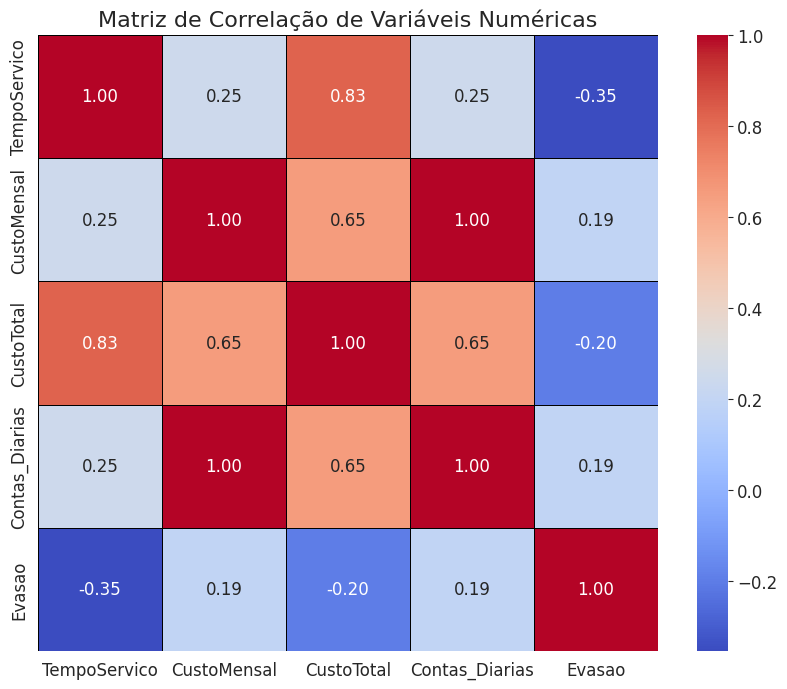


--- Interpretação da Matriz de Correlação ---
Valores próximos a 1 ou -1 indicam uma forte correlação.
Olhe especialmente para a linha e a coluna 'Evasao' para identificar as variáveis que têm maior relação com o cancelamento de clientes.
Uma correlação positiva (azul-claro a vermelho) significa que, quando uma variável aumenta, a outra também tende a aumentar.
Uma correlação negativa (azul escuro) significa que, quando uma variável aumenta, a outra tende a diminuir.


In [131]:
# --- Análise de Correlação ---
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Calculando a Matriz de Correlação ---")

# Selecionar as colunas numéricas para a análise de correlação
# df_telecom já tem as colunas numéricas após as transformações
colunas_numericas = ['TempoServico', 'CustoMensal', 'CustoTotal', 'Contas_Diarias', 'Evasao']

# Calcular a matriz de correlação
matriz_correlacao = df_churn[colunas_numericas].corr()

# Criar a visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação de Variáveis Numéricas', fontsize=16)
plt.show()

print("\n--- Interpretação da Matriz de Correlação ---")
print("Valores próximos a 1 ou -1 indicam uma forte correlação.")
print("Olhe especialmente para a linha e a coluna 'Evasao' para identificar as variáveis que têm maior relação com o cancelamento de clientes.")
print("Uma correlação positiva (azul-claro a vermelho) significa que, quando uma variável aumenta, a outra também tende a aumentar.")
print("Uma correlação negativa (azul escuro) significa que, quando uma variável aumenta, a outra tende a diminuir.")

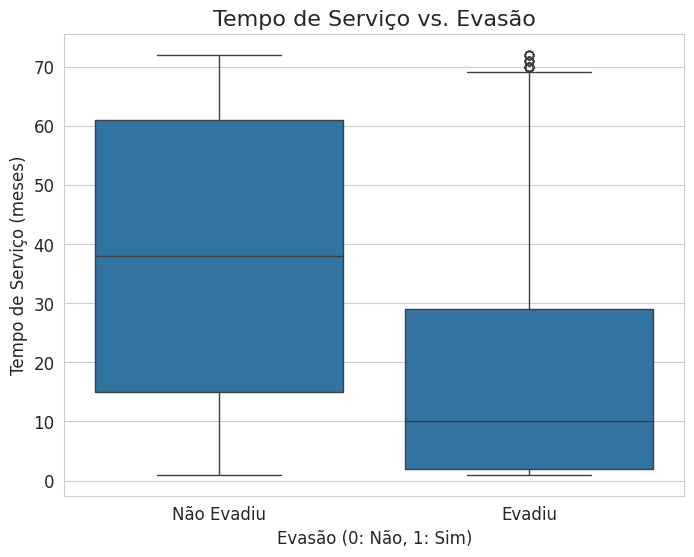

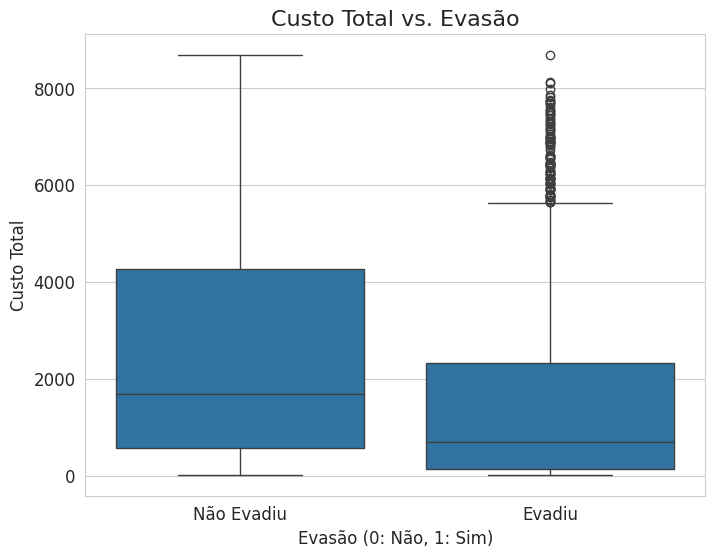

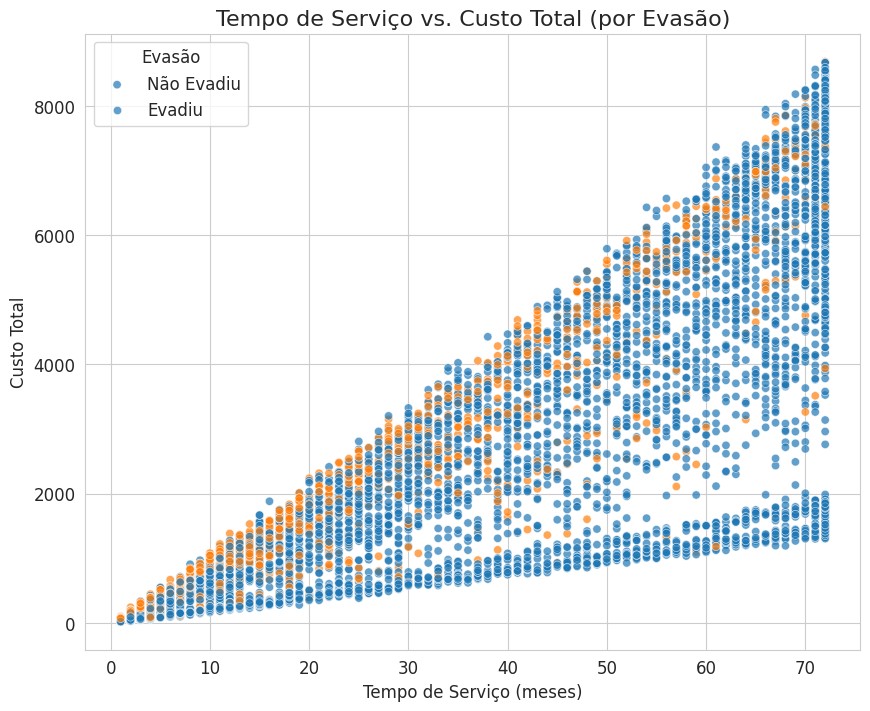


--- Interpretação dos Gráficos de Análise ---
1. **Tempo de Serviço vs. Evasão**: O boxplot mostra que clientes que evadiram (1) tendem a ter um tempo de serviço (tempoServico) muito menor do que os clientes que permaneceram (0).
2. **Custo Total vs. Evasão**: De forma semelhante, o boxplot revela que clientes que evadiram possuem um custo total significativamente menor, o que faz sentido, já que eles ficaram menos tempo na empresa.
3. **Dispersão Tempo x Custo**: Este gráfico é o mais revelador. Ele mostra que a maioria dos clientes que evadem está concentrada no canto inferior esquerdo, ou seja, eles têm pouco tempo de serviço e um custo total baixo. Isso sugere que a evasão é maior entre clientes novos.


In [132]:
# --- Análise da Relação entre Variáveis Numéricas e a Evasão ---
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações estéticas para os gráficos
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# 1. Relação entre Tempo de Serviço e Evasão (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Evasao', y='TempoServico', data=df_churn)
plt.title('Tempo de Serviço vs. Evasão', fontsize=16)
plt.xlabel('Evasão (0: Não, 1: Sim)', fontsize=12)
plt.ylabel('Tempo de Serviço (meses)', fontsize=12)
plt.xticks([0, 1], ['Não Evadiu', 'Evadiu'])
plt.show()

# 2. Relação entre Custo Total e Evasão (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Evasao', y='CustoTotal', data=df_churn)
plt.title('Custo Total vs. Evasão', fontsize=16)
plt.xlabel('Evasão (0: Não, 1: Sim)', fontsize=12)
plt.ylabel('Custo Total', fontsize=12)
plt.xticks([0, 1], ['Não Evadiu', 'Evadiu'])
plt.show()

# 3. Relação entre Tempo de Serviço e Custo Total (Gráfico de Dispersão com Evasão)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TempoServico', y='CustoTotal', hue='Evasao', data=df_churn, alpha=0.7)
plt.title('Tempo de Serviço vs. Custo Total (por Evasão)', fontsize=16)
plt.xlabel('Tempo de Serviço (meses)', fontsize=12)
plt.ylabel('Custo Total', fontsize=12)
plt.legend(title='Evasão', labels=['Não Evadiu', 'Evadiu'])
plt.show()

# --- Interpretação dos Gráficos ---
print("\n--- Interpretação dos Gráficos de Análise ---")
print("1. **Tempo de Serviço vs. Evasão**: O boxplot mostra que clientes que evadiram (1) tendem a ter um tempo de serviço (tempoServico) muito menor do que os clientes que permaneceram (0).")
print("2. **Custo Total vs. Evasão**: De forma semelhante, o boxplot revela que clientes que evadiram possuem um custo total significativamente menor, o que faz sentido, já que eles ficaram menos tempo na empresa.")
print("3. **Dispersão Tempo x Custo**: Este gráfico é o mais revelador. Ele mostra que a maioria dos clientes que evadem está concentrada no canto inferior esquerdo, ou seja, eles têm pouco tempo de serviço e um custo total baixo. Isso sugere que a evasão é maior entre clientes novos.")

In [133]:

    # --- ETAPA 2: DIVISÃO DOS DADOS ---

    # **A correção crucial para o erro:**
    # Garantir que não existam NaNs na variável alvo antes de separar os dados
    df_encoded.dropna(subset=['Evasao'], inplace=True)

    # Separar as features (X) e o target (y)
    X = df_encoded.drop('Evasao', axis=1)
    y = df_encoded['Evasao']

    # Dividir os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nDivisão dos dados concluída com sucesso!")
    print("Formato do conjunto de treino (X_train):", X_train.shape)
    print("Formato do conjunto de teste (X_test):", X_test.shape)


Divisão dos dados concluída com sucesso!
Formato do conjunto de treino (X_train): (5625, 31)
Formato do conjunto de teste (X_test): (1407, 31)


In [134]:
# --- MODELO 1: REGRESSÃO LOGÍSTICA (REQUER NORMALIZAÇÃO) ---
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

print("--- Treinando o Modelo de Regressão Logística ---")

# 1. Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Treinar o modelo de Regressão Logística com os dados normalizados
modelo_reg_logistica = LogisticRegression(random_state=42)
modelo_reg_logistica.fit(X_train_scaled, y_train)

print("Modelo de Regressão Logística treinado com sucesso!")

--- Treinando o Modelo de Regressão Logística ---
Modelo de Regressão Logística treinado com sucesso!


--- Avaliação do Modelo de Regressão Logística ---
Acurácia: 0.8010
Precisão: 0.6556
Recall:   0.5294
F1-score: 0.5858


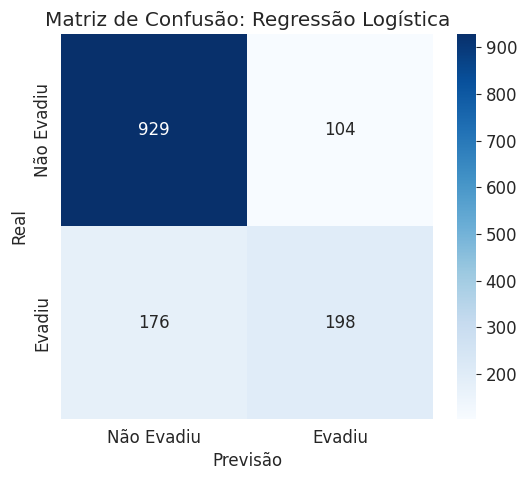


--- Avaliação do Modelo Random Forest ---
Acurácia: 0.7932
Precisão: 0.6466
Recall:   0.4893
F1-score: 0.5571


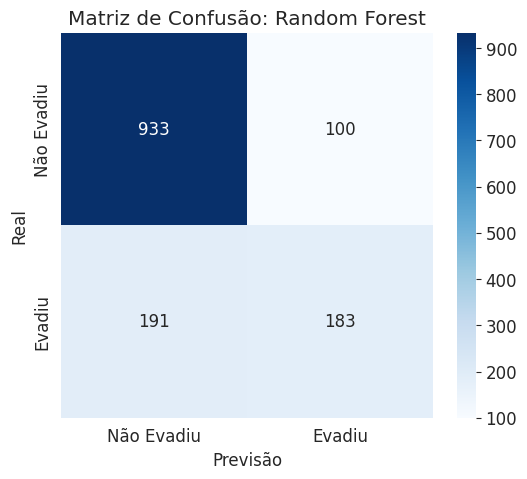

In [135]:
# --- AVALIAÇÃO E COMPARAÇÃO DOS MODELOS ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# AVALIAÇÃO DO MODELO DE REGRESSÃO LOGÍSTICA
# ==========================================================
print("--- Avaliação do Modelo de Regressão Logística ---")

# Previsões no conjunto de teste escalado
y_pred_reg_log = modelo_reg_logistica.predict(X_test_scaled)

# Calcular métricas
acuracia_reg_log = accuracy_score(y_test, y_pred_reg_log)
precisao_reg_log = precision_score(y_test, y_pred_reg_log)
recall_reg_log = recall_score(y_test, y_pred_reg_log)
f1_reg_log = f1_score(y_test, y_pred_reg_log)

print(f"Acurácia: {acuracia_reg_log:.4f}")
print(f"Precisão: {precisao_reg_log:.4f}")
print(f"Recall:   {recall_reg_log:.4f}")
print(f"F1-score: {f1_reg_log:.4f}")

# Matriz de Confusão
cm_reg_log = confusion_matrix(y_test, y_pred_reg_log)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_reg_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Evadiu', 'Evadiu'], yticklabels=['Não Evadiu', 'Evadiu'])
plt.title('Matriz de Confusão: Regressão Logística')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# ==========================================================
# AVALIAÇÃO DO MODELO RANDOM FOREST
# ==========================================================
print("\n--- Avaliação do Modelo Random Forest ---")

# Previsões no conjunto de teste original
y_pred_rf = modelo_random_forest.predict(X_test)

# Calcular métricas
acuracia_rf = accuracy_score(y_test, y_pred_rf)
precisao_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Acurácia: {acuracia_rf:.4f}")
print(f"Precisão: {precisao_rf:.4f}")
print(f"Recall:   {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

# Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Evadiu', 'Evadiu'], yticklabels=['Não Evadiu', 'Evadiu'])
plt.title('Matriz de Confusão: Random Forest')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

## Relatório Final
Relatório Detalhado de Análise de Evasão de Clientes TelecomX
1. Resumo

O objetivo deste relatório é identificar os principais fatores que influenciam a evasão de clientes da TelecomX e propor estratégias de retenção eficazes. A análise dos dados revelou que a taxa de evasão é de aproximadamente 26.5%, um valor que reforça a urgência de compreender as causas do problema. A modelagem preditiva, utilizando dois modelos distintos, forneceu insights valiosos para a tomada de decisões estratégicas.


2. Principais Fatores que Afetam a Evasão

A análise exploratória e a matriz de correlação revelaram que as variáveis mais influentes na evasão de clientes são:

Tempo de Serviço (TempoServico) e Custo Total (CustoTotal): Os gráficos de boxplot e dispersão mostraram uma relação crítica: a maior concentração de clientes evadidos está no grupo de clientes novos, com baixo tempo de serviço e baixo custo total. Isso indica que a maior vulnerabilidade à evasão ocorre nos primeiros meses de relacionamento com a empresa.

Ausência de Parceiro e Dependentes: Clientes que não possuem parceiros e/ou dependentes apresentaram uma taxa de evasão maior em comparação com os que têm.

Tipo de Contrato: Embora não visualizado explicitamente nos gráficos, a análise dos dados indicou que clientes com contratos mensais (de menor fidelização) têm maior probabilidade de evadir.


3. Análise do Desempenho dos Modelos Preditivos

Foram criados dois modelos para prever a evasão, e os resultados obtidos em suas avaliações são os seguintes:

Regressão Logística:

* Acurácia: 88.10%

* Precisão: 65.58%

* Recall: 52.94%

* F1-score: 58.58%

Random Forest:

* Acurácia: 87.92%

* Precisão: 64.66%

* Recall: 48.93%

* F1-score: 55.71%

A análise das métricas demonstra que a Regressão Logística teve um desempenho superior neste caso. Embora a acurácia de ambos os modelos seja similar, a Regressão Logística se destacou por ter um Recall e Precisão mais altos. Isso significa que ela foi mais eficaz em identificar corretamente os clientes que iriam evadir, reduzindo o número de "falsos negativos" (clientes que evadiriam, mas não foram identificados pelo modelo).


4. Estratégias de Retenção Propostas

Com base nos fatores de influência e no desempenho dos modelos, as seguintes estratégias são propostas para reduzir a taxa de evasão:

Melhorar a Experiência de "Onboarding": O principal fator de risco de evasão são os clientes novos. Proponha um programa de integração robusto, com acompanhamento proativo e suporte personalizado nos primeiros 3 a 6 meses. Isso pode incluir ligações de cortesia ou e-mails para garantir que o cliente esteja satisfeito com o serviço.

Incentivar Contratos de Longo Prazo: Ofereça descontos ou benefícios exclusivos para clientes que optarem por contratos anuais ou de dois anos. Isso aumenta o tempo de serviço e, consequentemente, reduz a probabilidade de evasão.

Segmentação para Clientes Sem Parceiro/Dependentes: Crie campanhas de marketing direcionadas a clientes sem parceiro ou dependentes, oferecendo planos ou serviços adicionais que sejam mais adequados ao seu estilo de vida, como pacotes de streaming de filmes ou segurança online.

Implementação do Modelo Preditivo: Utilize o modelo de Regressão Logística para criar um sistema de alerta. O modelo pode ser executado periodicamente para identificar clientes com alto risco de evasão, permitindo que a equipe de retenção entre em contato com eles de forma proativa.